# Evaluate training

## Plot losses

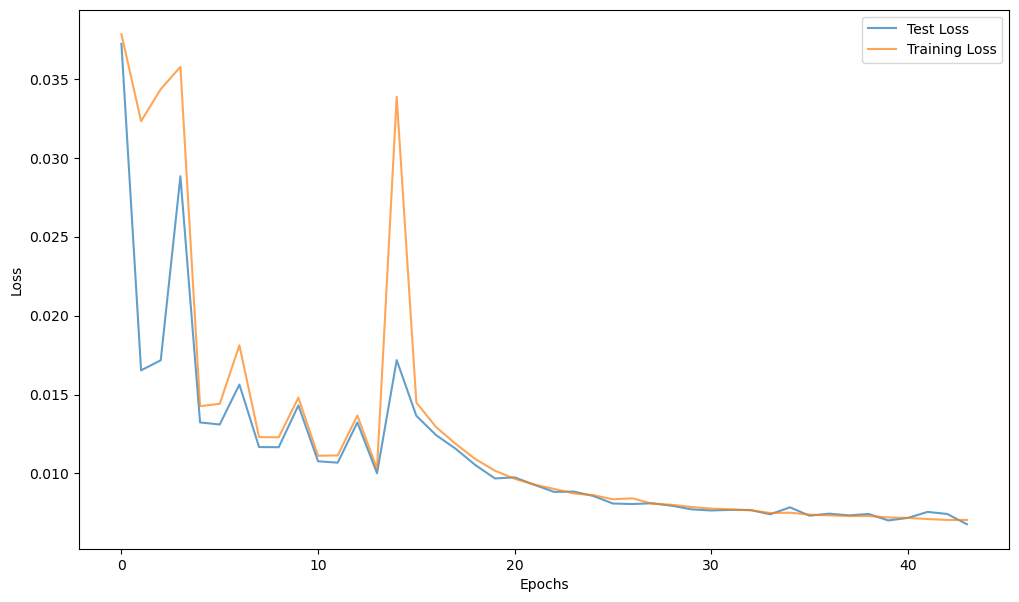

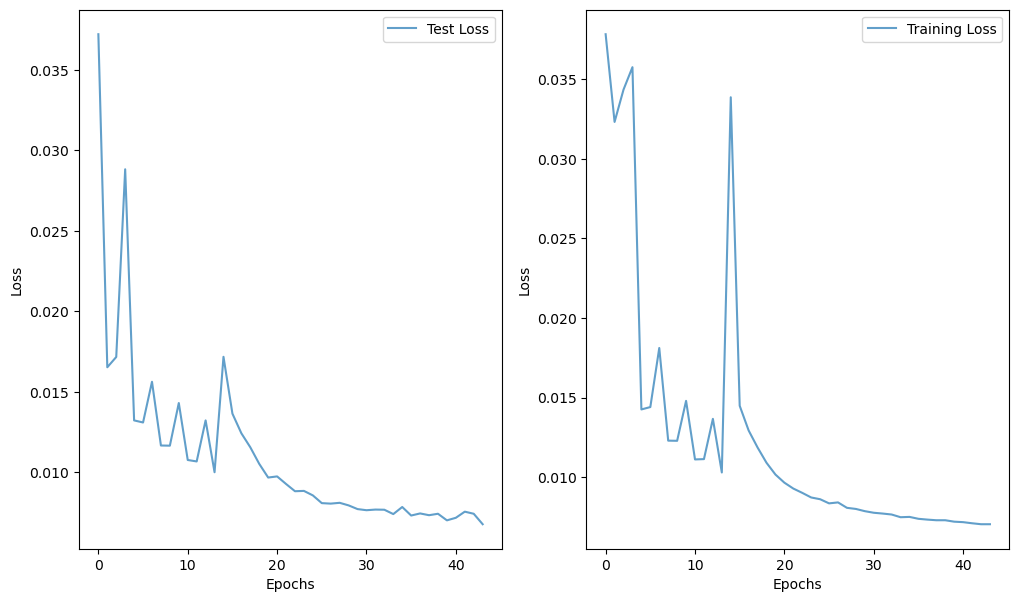

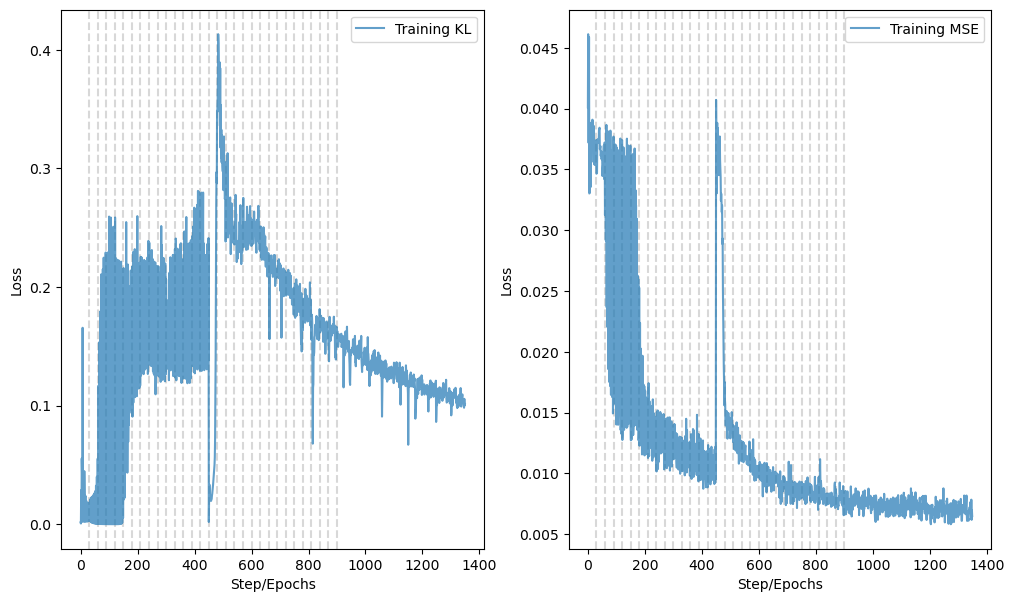

In [3]:
import re
import numpy as np
import sys
import matplotlib.pyplot as plt
sys.path.append('../')

path = '/home/x_leomo/saxsdiff/users/Diff_SAXS_reconstruction/debugging/VAE_test_constant_0.001_latent8_log'
file = f'{path}/log.txt'

# Containers
train_loss, train_mse, train_kl = [], [], []
Tr_loss , test_loss, test_mse, test_kl = [], [], [], []

with open(file, 'r') as f:
    for line in f:
        # Match training lines
        match_train = re.match(r".*Loss:\s*([\d.]+),\s*MSE:\s*([\d.]+),\s*KL:\s*([\d.]+)", line)
        if match_train and "Summary" not in line:
            loss, mse, kl = map(float, match_train.groups())
            train_loss.append(loss)
            train_mse.append(mse)
            train_kl.append(kl)
            continue

        # Match summary lines
        match_summary = re.match(
            r".*TrainLoss:\s*([\d.]+),\s*TestLoss:\s*([\d.]+),\s*TestMSE:\s*([\d.]+),\s*TestKL:\s*([\d.]+)",
            line,
        )
        if match_summary:
            tr_loss, te_loss, te_mse, te_kl = map(float, match_summary.groups())
            test_loss.append(te_loss)
            test_mse.append(te_mse)
            test_kl.append(te_kl)
            Tr_loss.append(tr_loss)

# Convert to numpy arrays
train_loss = np.array(Tr_loss)
test_loss = np.array(test_loss)

# Plot
fig, ax = plt.subplots(1,1, figsize=(12,7))
ax.plot(test_loss, label="Test Loss", alpha=0.7)

ax.set_ylabel("Loss")
ax.set_xlabel("Epochs")


ax.plot(train_loss, label="Training Loss", alpha=0.7)
ax.legend()
fig.savefig(f'{path}test_train_loss_same_plot.png')
plt.show()


# Plot
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,7))
ax1.plot(test_loss, label="Test Loss", alpha=0.7)

ax1.set_ylabel("Loss")
ax1.set_xlabel("Epochs")
ax1.legend()

ax2.plot(train_loss, label="Training Loss", alpha=0.7)

ax2.set_ylabel("Loss")
ax2.set_xlabel("Epochs")
ax2.legend()
fig.savefig(f'{path}test_train_loss_plot.png')
plt.show()


# Plot
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,7))
for i in range(1,31):
    ax1.axvline(i*30, color='gray', linestyle='--', alpha=0.3)
    ax2.axvline(i*30, color='gray', linestyle='--', alpha=0.3)
ax1.plot(train_kl, label="Training KL", alpha=0.7)

ax1.set_ylabel("Loss")
ax1.set_xlabel("Step/Epochs")
ax1.legend()

ax2.plot(train_mse, label="Training MSE", alpha=0.7)

ax2.set_ylabel("Loss")
ax2.set_xlabel("Step/Epochs")
#ax2.set_xlim([-30,930])
ax2.legend()
fig.savefig(f'{path}KL_mse.png')
plt.show()

## PCA of latent space

In [ ]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from VAE import *

def load_tfrecord_dataset(tfrecord_path, batch_size=16, shuffle=False):
    feature_description = {
        'data': tf.io.FixedLenFeature([32*32*32], tf.float32),
    }
    def _parse_function(example_proto):
        parsed = tf.io.parse_single_example(example_proto, feature_description)
        volume = tf.reshape(parsed['data'], (32,32,32,1))
        return volume

    dataset = tf.data.TFRecordDataset(tfrecord_path)
    dataset = dataset.map(_parse_function)
    if shuffle:
        dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.batch(batch_size)
    return dataset

def plot_latent_pca(vae, tfrecord_path, save_path=None, batch_size=16):
    """
    Encode data using VAE, compute PCA of latent space, and plot first 2 components.
    Also save mean, std, min, max for each latent variable.
    """
    dataset = load_tfrecord_dataset(tfrecord_path, batch_size=batch_size)
    z_list = []

    for batch in dataset:
        mean, logvar = vae.encode(batch)
        z_list.append(mean.numpy())

    z = np.concatenate(z_list, axis=0)

    # Compute statistics for each latent dimension
    latent_mean = np.mean(z, axis=0)
    latent_std  = np.std(z, axis=0)
    latent_min  = np.min(z, axis=0)
    latent_max  = np.max(z, axis=0)

    # Stack them as columns: mean, std, min, max
    latent_stats = np.vstack((latent_mean, latent_std, latent_min, latent_max)).T

    # Save to file
    if save_path:
        os.makedirs(save_path, exist_ok=True)
        np.savetxt(f'{save_path}/latent_stats.txt', latent_stats, 
                   header='mean std min max', fmt='%.6f')
        print(f"Saved latent statistics to {save_path}/latent_stats.txt")

    print("Total latent shape:", z.shape)
    print("Latent statistics shape:", latent_stats.shape)

    # PCA
    pca = PCA(n_components=2)
    z_pca = pca.fit_transform(z)

    # Plot PCA
    plt.figure(figsize=(8, 6))
    plt.scatter(z_pca[:, 0], z_pca[:, 1], alpha=0.7, s=20)
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.grid(True)
    if save_path:
        plt.savefig(f'{save_path}/PCA_latent.png', dpi=200)
        print(f"Saved PCA plot to {save_path}/PCA_latent.png")
    plt.show()


## Encode/Decode example 

In [32]:
"""
Script to encode a pair of voxel grids, save latent vectors,
and decode them back to voxel grids.
"""
import numpy as np
from pathlib import Path
import tensorflow as tf
import result2pdb
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from VAE import *
# Import your helper functions
VOX_SHAPE = (31,31,31)



encoder_path_tf = f"{path}/encoder_model.tf"
decoder_path_tf = f"{path}/decoder_model.tf"

if os.path.isdir(encoder_path_tf) and os.path.isdir(decoder_path_tf):
    # Load .tf directories
    encoder = tf.keras.layers.TFSMLayer(encoder_path_tf, call_endpoint="serving_default")
    decoder = tf.keras.layers.TFSMLayer(decoder_path_tf, call_endpoint="serving_default")
else:
    # Fallback to default directories
    encoder = tf.keras.layers.TFSMLayer(f"{path}/encoder_model", call_endpoint="serving_default")
    decoder = tf.keras.layers.TFSMLayer(f"{path}/decoder_model", call_endpoint="serving_default")

vae = VAE(z_dim, encoder, decoder)

# ───────────────────────── File paths ─────────────────────────
# Replace with your voxel .npy files
voxel_file1 ='/home/leonardo/testing_saxs/test_data_cont/pdbs/voxels/Ref_pred_continuous_cube.npy'
voxel_file2 = "/home/leonardo/testing_saxs/test_data_cont/pdbs/voxels/unrelaxed_model_1_pred_105_rand0.5_dropout.pdb_all_atm_continuous_cube.npy"

# Outputs
latent_outfile = f"{path}/latents.txt"
decoded_out1 = f"{path}/decoded_voxel1.npy"
decoded_out2 = f"{path}/decoded_voxel2.npy"

diff_out1 = f"{path}/diff_voxel1.npy"
diff_out2 = f"{path}/diff_voxel2.npy"

# ───────────────────────── Load voxels ─────────────────────────
vox1 = np.load(voxel_file1)
vox2 = np.load(voxel_file2)
vox1 = np.clip(vox1,0,1)
vox2 = np.clip(vox2,0,1)

diff1 = vox1 - vox2
np.save(diff_out1, diff1)
diff2 = vox2 - vox1
np.save(diff_out2, diff2)

diff1 = np.pad(diff1, pad_width=((0, 1), (0, 1), (0, 1)), mode="constant")
diff2 = np.pad(diff2, pad_width=((0, 1), (0, 1), (0, 1)), mode="constant")
print(diff1.max(), diff1.min())
# Make batch
voxels = np.stack([diff1, diff2], axis=0)[..., np.newaxis].astype(np.float32)
# shape: (2, 32, 32, 32, 1)


# ───────────────────────── Encode ─────────────────────────
latents, _ = vae.encode(voxels)
#print("Latent vectors shape:", latents.shape)

# Save latent vectors as txt
np.savetxt(latent_outfile, latents, fmt="%.6f")
#print(f"Saved latent vectors to {latent_outfile}")

# ───────────────────────── Decode ─────────────────────────
decoded = vae.decode(latents)
print("Decoded voxel grids shape:", decoded.shape)
print(diff1.shape)


# Save decoded outputs

np.save(decoded_out1, decoded[0,...,0])
np.save(decoded_out2, decoded[1,...,0])
print(decoded[0].numpy().max())
print(decoded[0].numpy().min())
print(decoded[0].numpy().mean())
#result2pdb.write_single_pdb(decoded[0],'/home/leonardo/testing_saxs/difference_model_many_dark','diff1',rmax=50)
#result2pdb.write_single_pdb(decoded[1],'/home/leonardo/testing_saxs/difference_model_many_dark','diff2',rmax=50)

print(f"Saved decoded voxels to {decoded_out1} and {decoded_out2}")


1.0 -1.0
Decoded voxel grids shape: (2, 32, 32, 32, 1)
(32, 32, 32)
0.9623225
-0.99288774
0.00035648956
Saved decoded voxels to /home/leonardo/testing_saxs/VAE_test_constant_0.0001_latent8_log/decoded_voxel1.npy and /home/leonardo/testing_saxs/VAE_test_constant_0.0001_latent8_log/decoded_voxel2.npy


## Voxel to density

In [34]:
from density_manipulation import *
save_path_testmap = path
# Encode-Decode example 
path = save_path_testmap
decoded = np.load(f'{path}/decoded_voxel2.npy')[:31,:31, :31]
print(decoded.shape)
print('Decoded Voxel:')
print('Dimensions:',decoded.shape)
print('Max:',decoded.max())
print('Min:',decoded.min())
print('Mean:',decoded.mean())
#actual = (actual - actual.mean()) / actual.std()
output_map_file = f'{path}/vae_decoded.ccp4' 
create_ccp4_map_(decoded, output_map_file, voxel_size=3.33, scaling_factor_file='/home/leonardo/testing_saxs/test_data_cont/pdbs/voxels/scaling_factor/unrelaxed_model_1_pred_105_rand0.5_dropout.pdb_all_atm_scale_factor.npy')


actual = np.load(f'{path}/diff_voxel2.npy')
print('Actual Voxel:')
print('Dimensions:',actual.shape)
print('Max:',actual.max())
print('Min:',actual.min())
print('Mean:',actual.mean())
#prediction = (prediction - prediction.mean()) / prediction.std()
output_map_file = f'{path}/vae_diff.ccp4' 
create_ccp4_map_(actual, output_map_file, voxel_size=3.33, scaling_factor_file='/home/leonardo/testing_saxs/test_data_cont/pdbs/voxels/scaling_factor/unrelaxed_model_1_pred_105_rand0.5_dropout.pdb_all_atm_scale_factor.npy')

rmse = np.mean(np.square(actual-decoded))
print('MSE:',rmse)

corr = np.corrcoef(actual.flatten(), decoded.flatten())
print('Correlation:',corr[1][0])

(31, 31, 31)
Decoded Voxel:
Dimensions: (31, 31, 31)
Max: 0.8181295
Min: -0.9864998
Mean: -0.0032631746
Loaded scaling factor: 1.6578539342949108
Loaded scaling factor
Grid shape: (31, 31, 31)
Voxel size (Å): 2.0086208628604285
Real box size (Å): (62.26724674867329, 62.26724674867329, 62.26724674867329)
✅ CCP4 map saved to: /home/leonardo/testing_saxs/VAE_test_constant_0.0001_latent8_log/vae_decoded.ccp4
Unit cell (Å): <gemmi.UnitCell(62.2672, 62.2672, 62.2672, 90, 90, 90)>
Actual Voxel:
Dimensions: (31, 31, 31)
Max: 1.0
Min: -1.0
Mean: -0.0011062838731018172
Loaded scaling factor: 1.6578539342949108
Loaded scaling factor
Grid shape: (31, 31, 31)
Voxel size (Å): 2.0086208628604285
Real box size (Å): (62.26724674867329, 62.26724674867329, 62.26724674867329)
✅ CCP4 map saved to: /home/leonardo/testing_saxs/VAE_test_constant_0.0001_latent8_log/vae_diff.ccp4
Unit cell (Å): <gemmi.UnitCell(62.2672, 62.2672, 62.2672, 90, 90, 90)>
MSE: 0.015398249668133355
Correlation: 0.8173382715367017


## Decode latent check 

In [6]:
import numpy as np
import tensorflow as tf
from density_manipulation import create_ccp4_map_
from VAE import *

def decode_and_save_ccp4(latent_vector, vae, output_map_file, voxel_size=3.33, scaling_factor_file=None):
    """
    Decode a latent vector using VAE and save as CCP4 map.
    
    Parameters:
    - latent_vector: np.ndarray of shape (1, z_dim) or (z_dim,)
    - vae: VAE instance with .decode() method
    - output_map_file: Path to save CCP4 map
    - voxel_size: Size of voxel in Å
    - scaling_factor_file: Optional path to scaling factor file
    """
    # Ensure latent vector is 2D
    latent_vector = np.array(latent_vector, dtype=np.float32).reshape(1, -1)
    
    # Decode to voxel grid
    decoded = vae.decode(latent_vector)
    decoded = decoded.numpy()[0, ..., 0]  # shape: (32, 32, 32)
    
    # Crop to 31³ if needed
    decoded = decoded[:31, :31, :31]
    
    # Save CCP4 map
    create_ccp4_map_(decoded, output_map_file, voxel_size=voxel_size, scaling_factor_file=scaling_factor_file)
    
    print(f"Decoded voxel shape: {decoded.shape}")
    print(f"Saved CCP4 map to: {output_map_file}")
    return decoded


def generate_original_group(init, num):
    original_group = np.zeros(shape=(num, 256))
    for ii in range(256):
        original_group[:, ii] = np.random.normal(init[ii, 0], init[ii, 1], size=num)
    original_group = original_group
    return original_group

latent = np.loadtxt("/home/leonardo/testing_saxs/VAE_test_constant_0.001_long/latents.txt")  # or any latent vector
print(latent.shape)
#test = generate_original_group(latent,10)
#print(test[7])


output_map = "/home/leonardo/testing_saxs/test_new_main/output_map.ccp4"
encoder = tf.keras.layers.TFSMLayer(f"/home/leonardo/testing_saxs/VAE_test_constant_0.001_long/decoder_model", call_endpoint="serving_default")
decoder = tf.keras.layers.TFSMLayer(f"/home/leonardo/testing_saxs/VAE_test_constant_0.001_long/decoder_model", call_endpoint="serving_default")

vae = VAE(z_dim, encoder, decoder)

decoded_voxel = decode_and_save_ccp4(latent[1], vae, output_map, voxel_size=3.33,
                                     scaling_factor_file="/home/leonardo/testing_saxs/test_data_cont/pdbs/voxels/scaling_factor/Ref_pred_scale_factor.npy")

(2, 256)


2025-11-14 16:39:10.998296: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 90300


Loaded scaling factor: 2.1247568408766697
Grid shape: (31, 31, 31)
Voxel size (Å): 1.5672381591796876
Real box size (Å): (48.584382934570314, 48.584382934570314, 48.584382934570314)
✅ CCP4 map saved to: /home/leonardo/testing_saxs/test_new_main/output_map.ccp4
Unit cell (Å): <gemmi.UnitCell(48.5844, 48.5844, 48.5844, 90, 90, 90)>
Decoded voxel shape: (31, 31, 31)
Saved CCP4 map to: /home/leonardo/testing_saxs/test_new_main/output_map.ccp4


In [15]:
latent = np.loadtxt("/home/leonardo/testing_saxs/VAE_test_constant_0.001_long/latent_init.txt").T 
latent_test = np.loadtxt("/home/leonardo/testing_saxs/VAE_test_constant_0.001_long/latents.txt")[1] 
print(latent[0])
latent[0] = latent_test
np.savetxt("/home/leonardo/testing_saxs/VAE_test_constant_0.001_long/latent_init_2.txt", latent.T)

[ 0.35951999  0.78980052 -0.39196557 -0.53845346  0.26087108 -0.31751966
  0.52527446  0.57069677 -0.3541249   0.04724178 -0.15795211 -0.55235988
 -0.23531398  0.29973561 -0.53657937 -0.54930818 -0.57621193 -0.60207224
  0.18470217 -0.57986039  0.11296358  0.03894094  0.60124588 -0.52308136
 -0.67044544 -0.51401699 -0.55797774 -0.50389308  0.25955725  0.57374018
  0.55481726 -0.60840547  0.51252884  0.08771208 -0.57469201  0.49303657
 -0.53856206 -0.64984244 -0.62844402  0.51981574  0.60712075  0.11891172
  0.19010767  0.09024186  0.64689291  0.73518419  0.25975379  0.57196403
 -0.28363964 -0.50075042 -0.42938909  0.45519459 -0.37626067  0.15113764
  0.29862222  0.50718397  0.20169224  0.74736995  0.03678738  0.52842879
 -0.358257    0.02349917  0.76059949  0.17417231  0.36731622 -0.25982842
  0.63441002  0.59402502  0.67913634 -0.58229256  0.00689331  0.3472048
 -0.80060625 -0.43424386  0.73481578 -0.35893005 -0.42592078 -0.54795778
 -0.21381867 -0.52124447 -0.3779729  -0.37930441  0.

# Debug reconstructions


# Calculate scattering of extrapolated

In [361]:
a= (np.load('/home/leonardo/testing_saxs/test_data_cont/pdbs/voxels/scaling_factor/unrelaxed_model_1_pred_105_rand0.5_dropout.pdb_all_atm_scale_factor.npy'))
b = (np.load('/home/leonardo/testing_saxs/test_data_cont/pdbs/voxels/scaling_factor/Ref_pred_scale_factor.npy'))
print(a)
print(b)
print(a/b)
print(b/a)

[1.65785393]
[2.12475684]
[0.78025584]
[1.28163091]


In [11]:
for n in range(10):
    latent = np.load(f'/home/leonardo/testing_saxs/test_new_main/top_{n}_latent.npy')
    print(latent[:10])

[ 2.43039893  1.78170842  1.72007505 -1.11334778 -0.21637442  0.35015952
  0.55484593  1.23577866  1.02384573 -2.17603704]
[ 2.27724259  2.31457242  2.81077722 -3.01475581 -1.15072204 -1.49927427
 -0.66209957  2.63238037  3.67493941 -1.69619455]
[ 1.38786047  2.0334255  -1.33427823 -0.35922471  0.21673119  2.1866011
 -0.05391915  2.83045006  0.35293382 -1.57887133]
[ 3.04936973  1.80762866 -1.04251961  0.73743267  0.18369086 -1.31506334
  0.18698855  1.36396175 -0.99802268 -0.67916808]
[ 1.02725738  1.46961344  1.34212816 -0.97632524 -0.13254058  0.47764793
  0.33984845  2.10206528  0.83243965 -2.22574783]
[ 0.82958733  1.19688052  2.43165011 -1.99446799  0.28601735  1.32686245
  0.9934366   0.76483095 -0.01573925  0.3806002 ]
[ 1.35267812  1.39208097  0.96944996 -0.48261547 -0.96222468  0.3895732
  0.88102086  1.7489811   3.95600241 -0.20405869]
[ 1.51652814  0.7837913  -1.53307354 -1.13358228 -0.44426014  0.63630958
  0.38313091  0.76223904  2.31710584 -1.86590109]
[ 0.12302034  0.86

In [1]:
import numpy as np
from VAE import *

path = '/home/leonardo/testing_saxs/VAE_test_constant_0.001_long'


encoder_path_tf = f"{path}/encoder_model.tf"
decoder_path_tf = f"{path}/decoder_model.tf"

if os.path.isdir(encoder_path_tf) and os.path.isdir(decoder_path_tf):
    # Load .tf directories
    encoder = tf.keras.layers.TFSMLayer(encoder_path_tf, call_endpoint="serving_default")
    decoder = tf.keras.layers.TFSMLayer(decoder_path_tf, call_endpoint="serving_default")
else:
    # Fallback to default directories
    encoder = tf.keras.layers.TFSMLayer(f"{path}/encoder_model", call_endpoint="serving_default")
    decoder = tf.keras.layers.TFSMLayer(f"{path}/decoder_model", call_endpoint="serving_default")




vae = VAE(z_dim, encoder, decoder)


# Pick 2 random latent vectors
latent_test = np.random.normal(0, 1, size=(2, 256)).astype(np.float32)
voxel1 = vae.decode(latent_test[0:1]).numpy()
voxel2 = vae.decode(latent_test[1:2]).numpy()

# Compute mean absolute difference
diff = np.mean(np.abs(voxel1 - voxel2))
print("Mean absolute difference between decoded voxels:", diff)

# Optional: compute correlation
voxels_flat = np.stack([voxel1.flatten(), voxel2.flatten()])
corr = np.corrcoef(voxels_flat)[0, 1]
print("Correlation between decoded voxels:", corr)


2025-11-18 16:16:05.399914: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-18 16:16:05.441856: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-18 16:16:06.326900: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
I0000 00:00:1763478967.519412  614639 gpu_device.cc:2020] Created device /job:lo

KeyboardInterrupt: 

In [2]:
from map2iq_shape import * 
import matplotlib.pyplot as plt
import processSaxs as ps
import map2iq_shape as map2iq
from sklearn.metrics import r2_score

S_factor 2.1247568408766697
photoyield: 0.0006912551412925281
0.0006744314826042287
Chi² 8.869173365934906e-05
Chi² 8.865477580103752e-05
R² 0.5628014625091495
R² 0.5631657479827095


/tmp/ipykernel_70909/339719511.py:35: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_70909/339719511.py:44: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


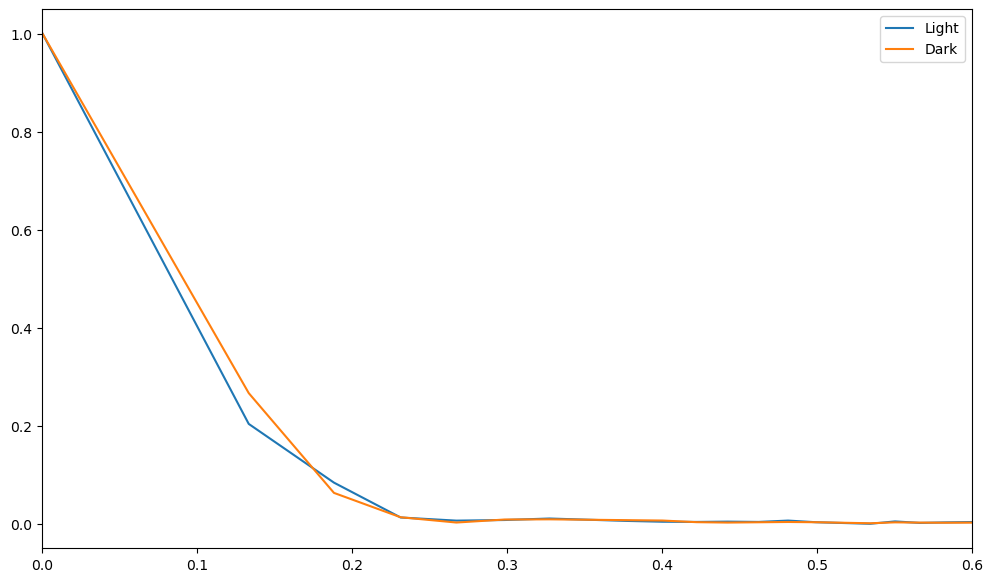

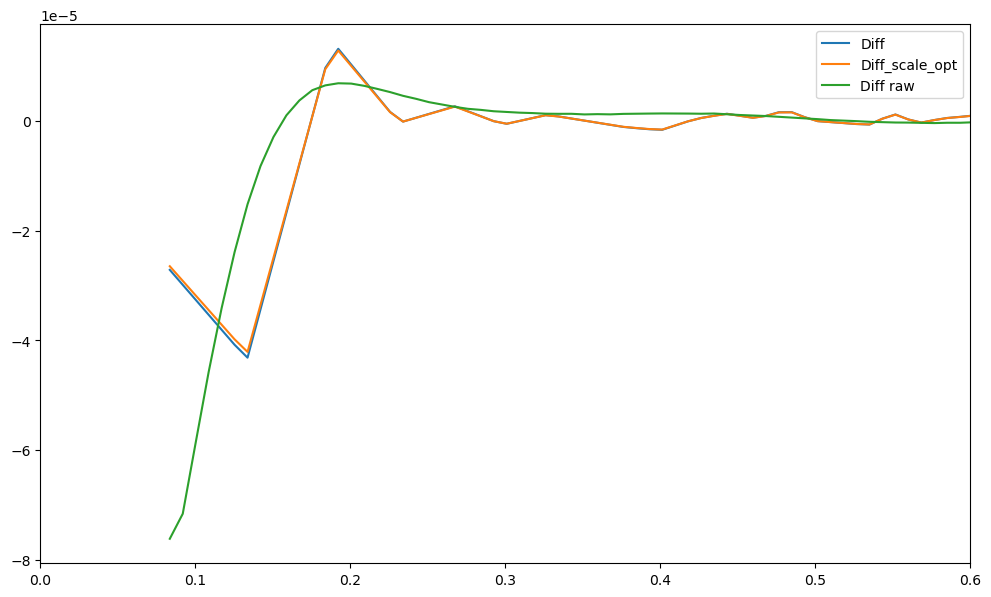

In [14]:
n = 0
scale_factor = np.load('/home/leonardo/testing_saxs/test_full_search_gene_init/ground_state_scale_factor.npy')
scale_factor_light = np.load(f'/home/leonardo/testing_saxs/test_full_search_gene_init/top_{n}_sfactor.npy')
print('S_factor',scale_factor_light)

scale =np.load(f'/home/leonardo/testing_saxs/test_full_search_gene_init/top_{n}_scale.npy')
print('photoyield:',scale)

voxel_light = np.load(f'/home/leonardo/testing_saxs/test_full_search_gene_init/top_{n}_extrapolated.npy')
voxel_dark = np.load('/home/leonardo/testing_saxs/test_full_search_gene_init/ground_state_continuous_cube.npy')

voxel_size = 100 / (31 * scale_factor_light)
q_light, I_light = fft_intensity_scale_factor(voxel_light, voxel_size)
I_light = I_light/I_light[0]


voxel_size = 100 / (31 * scale_factor)
#voxel_dark = voxel_dark.clip(0,1)
q_dark, I_dark = fft_intensity_scale_factor(voxel_dark, voxel_size)
I_dark = I_dark/I_dark[0]


I_light = np.interp(q_dark[:q_light.shape[0]],q_light,I_light)

diff_data_original = np.loadtxt('/home/leonardo/testing_saxs/test_new_main/diff_data.dat',delimiter=',').T

I_delta = np.interp(diff_data_original[0],q_light,I_light-I_dark[:q_light.shape[0]])


fig, ax = plt.subplots(1,1, figsize=(12,7))
ax.plot(q_light,I_light,label='Light')
ax.plot(q_light,I_dark,label='Dark')
ax.legend()
ax.set_xlim([0,0.6])
fig.show()

scale_opt = np.dot(diff_data_original[1], I_delta)/np.dot(I_delta,I_delta)
fig, ax = plt.subplots(1,1, figsize=(12,7))
ax.plot(diff_data_original[0],I_delta*scale,label='Diff')
ax.plot(diff_data_original[0],I_delta*scale_opt,label='Diff_scale_opt')
ax.plot(diff_data_original[0],diff_data_original[1],label='Diff raw')
ax.legend()
ax.set_xlim([0,0.6])
fig.show()

index = diff_data_original[0] < .6


print(scale_opt)
print('Chi²',np.linalg.norm((diff_data_original[1][index] - (I_delta[index]*scale))))
print('Chi²',np.linalg.norm((diff_data_original[1][index] - (I_delta[index]*scale_opt))))

print('R²',r2_score(diff_data_original[1][index], I_delta[index]*scale))
print('R²',r2_score(diff_data_original[1][index], I_delta[index]*scale_opt))
